In [21]:
import creds
import requests
from requests.auth import HTTPBasicAuth
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

In [22]:
print(plt.style.available)
plt.rc('font', family='Georgia') 
plt.style.use('seaborn-darkgrid')

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


### Helper functions for communicating with the Spotify API

In [23]:
def get_token(username, password):
    res = requests.post('https://accounts.spotify.com/api/token/?grant_type=client_credentials', 
                        auth=(username, password),
                        headers={"Content-Type": "application/x-www-form-urlencoded"})
    return res.json()["access_token"]

def get_playlist(playlist_id, token):
    res = requests.get(f"https://api.spotify.com/v1/playlists/{playlist_id}/tracks",
                      headers = {"Authorization": "Bearer " + token})
    if res.status_code == 429:  # rate-limited
        time.sleep(5)
        print("We got rate limited! Please hold on 5 sec.")
        return get_playlist(playlist_id, token)
    
    data = res.json()
    items = data["items"]
    while data["next"] is not None:
        res = requests.get(data["next"],
                      headers = {"Authorization": "Bearer " + token})
        data = res.json()
        items = items + data["items"]
    return items

def get_audio_features(track_id, token):
    res = requests.get(f"https://api.spotify.com/v1/audio-features/{track_id}",
                      headers = {"Authorization": "Bearer " + token})
    if res.status_code == 429:  # rate-limited
        time.sleep(5)
        print("We got rate limited! Please hold on 5 sec.")
        return get_audio_features(track_id, token)
    
    data = res.json()
    return data

### Data processing and formatting

In [24]:
def process_playlist_items(items, access_token):
    artists = {}
    for track in items:
        artist = track["track"]["artists"][0]["name"]
        if artist not in artists:
            artists[artist] = {}
        audio_features = get_audio_features(track["track"]["id"], access_token)
        artists[artist][track["track"]["name"]] = {
            "name": track["track"]["name"],
            "artist": artist,
            "popularity": track["track"]["popularity"],
            "duration_ms": track["track"]["duration_ms"],
            "danceability": audio_features["danceability"],
            "energy": audio_features["energy"],
            "loudness": audio_features["loudness"],
            "speechiness": audio_features["speechiness"],
            "acousticness": audio_features["acousticness"],
            "instrumentalness": audio_features["instrumentalness"],
            "liveness": audio_features["liveness"],
            "valence": audio_features["valence"],
            "tempo": audio_features["tempo"],
            "key": audio_features["key"],
            "mode": audio_features["mode"]
        }
    return artists

def order_tracks(tracks):
    clusters = {}
    for artist in tracks:
        clusters[artist] = {}
        artist_tracks = dict(tracks[artist])
        while artist_tracks:
            track = artist_tracks.pop(list(artist_tracks)[0])
            track_parts = track["name"].split(" ")
            for k in reversed(range(1,len(track_parts))):
                sub_track = " ".join(track_parts[:k])
                cluster = [x for x in artist_tracks if artist_tracks[x]["name"].startswith(sub_track)]
                if (len(cluster) > 0):
                    track_cluster = {track["name"].replace(sub_track, "").strip(): track}
                    for x in cluster:
                        track_cluster[x.replace(sub_track, "").strip()] = artist_tracks[x]
                        artist_tracks.pop(x)
                    clusters[artist][re.sub(r'\s?[\\.,;:\-_]\s?$', '', sub_track)] = track_cluster
                    break
    return(clusters)

def ordered_tracks_to_data_frame(tracks):
    df = pd.DataFrame(columns=["composer", "concerto", "movement", "popularity", "duration_ms", "danceability", "energy", "loudness", "speechiness", "acousticness", "instrumentalness", "valence", "tempo","key","mode"])
    for artist in tracks:
        for concerto in tracks[artist]:
            for movement in tracks[artist][concerto]:
                df = df.append({**{
                    "composer": artist,
                    "concerto": concerto,
                    "movement": movement
                }, **tracks[artist][concerto][movement]}, ignore_index=True)
    return(df)

 - Generate an access token for Spotify
 - Retrieve all tracks from my piano concertos playlist
 - Process the tracks
 - List all piano concertos with 3 parts

In [25]:
access_token = get_token(creds.spotify_username, creds.spotify_password)

In [26]:
items = get_playlist("66OGbLoEFtJ2D3qxPOwsAV", access_token)

In [27]:
tracks = process_playlist_items(items, access_token)

In [28]:
ordered_tracks = order_tracks(tracks)
df = ordered_tracks_to_data_frame(ordered_tracks)

In [29]:
all_concertos = []
for artist in ordered_tracks:
    for concerto in ordered_tracks[artist]:
        if len(ordered_tracks[artist][concerto]) == 3:
            all_concertos.append(concerto)
            print("%-30s %s" % (artist, concerto))


Ludwig van Beethoven           Piano Concerto No. 1 in C Major, Op. 15
Ludwig van Beethoven           Piano Concerto No. 2 in B Flat Major, Op. 19
Ludwig van Beethoven           Piano Concerto No. 3 in C Minor, Op. 37
Ludwig van Beethoven           Piano Concerto No. 4 in G Major, Op. 58
Ludwig van Beethoven           Piano Concerto No. 5 in E Flat Major, Op. 73 "Emperor"
Sergei Rachmaninoff            Piano Concerto No. 1 in F-Sharp Minor, Op. 1
Sergei Rachmaninoff            Piano Concerto No. 2 in C Minor, Op. 18
Sergei Rachmaninoff            Piano Concerto No. 3 in D Minor, Op. 30
Sergei Rachmaninoff            Piano Concerto No. 4 in G Minor, Op. 40
Wolfgang Amadeus Mozart        Piano Concerto No. 1 in F Major, K. 37
Wolfgang Amadeus Mozart        Piano Concerto No. 2 in B-Flat Major, K. 39
Wolfgang Amadeus Mozart        Piano Concerto No. 3 in D Major, K. 40
Wolfgang Amadeus Mozart        Piano Concerto No. 4 in G Major, K. 41
Wolfgang Amadeus Mozart        Piano Concerto No. 5

### Piano concerto keys

This is a flawed illustration of the keys of all the considered piano concertos. We are using the keys as they are recognized by Spotify but ideally, we'd use the keys as mentioned by the composer in the piano concerto's name.

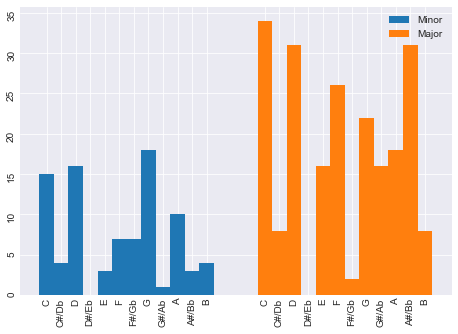

In [30]:
stats_minor = df[df["mode"] == 0]["key"].value_counts()
keys_minor = list(stats_minor.keys())
stats_major = df[df["mode"] == 1]["key"].value_counts()
keys_major = list(stats_minor.keys())

keys = ["C", "C#/Db", "D", "D#/Eb", "E", "F", "F#/Gb", "G", "G#/Ab", "A", "A#/Bb", "B"]
ticks = []
tick_locs = []
for i,key in enumerate(keys):
    tick_locs.append(i)
    ticks.append(key)
    tick_locs.append(i + 15)
    ticks.append(key)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(np.array(keys_minor), stats_minor[keys_minor], label="Minor", width=1)
ax.bar(np.array(keys_major) + 15, stats_major[keys_major], label="Major", width=1)
ax.legend();
ax.set_xticks(tick_locs);
ax.set_xticklabels(ticks);
ax.tick_params(labelrotation = 90)

### Boxplots
Boxplots of all the properties, relative across the three parts in 3-part piano concerts.

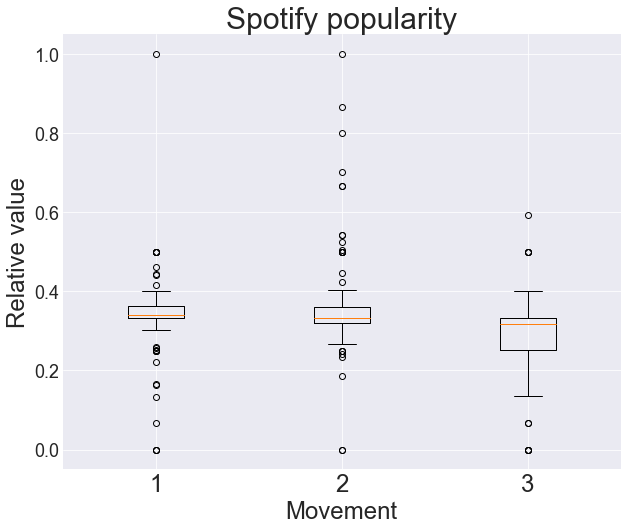

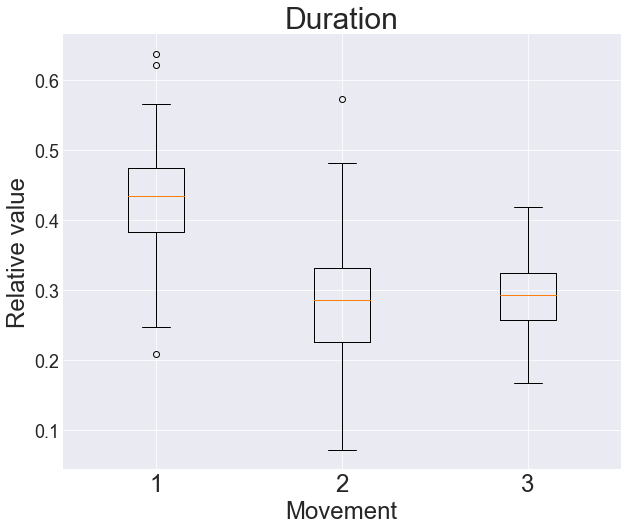

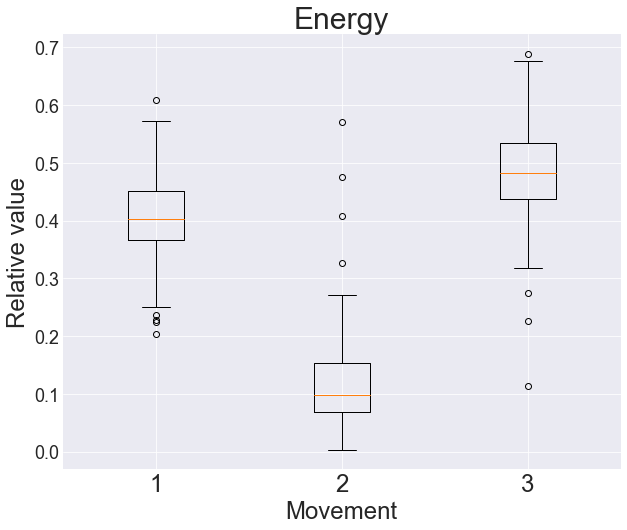

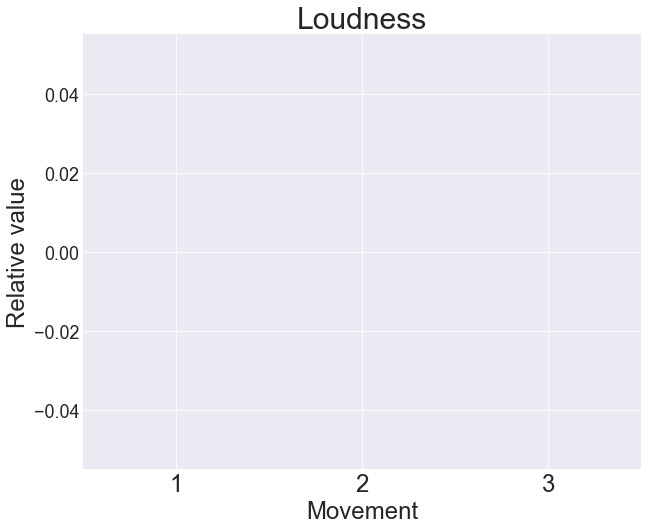

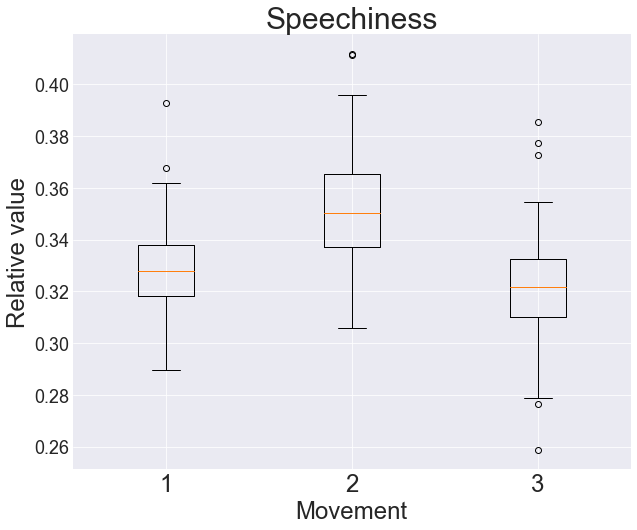

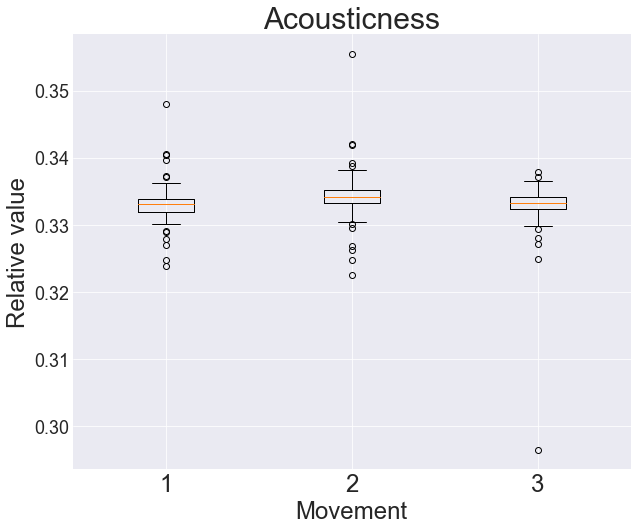

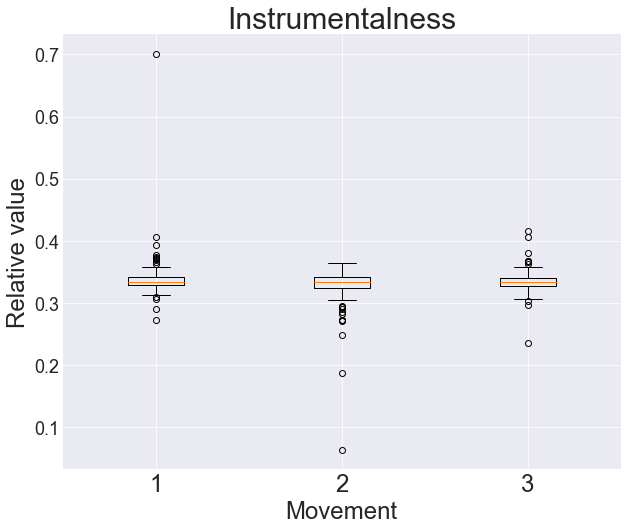

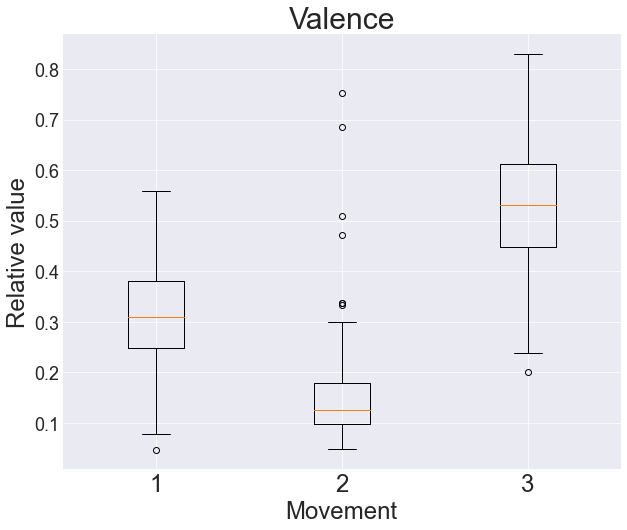

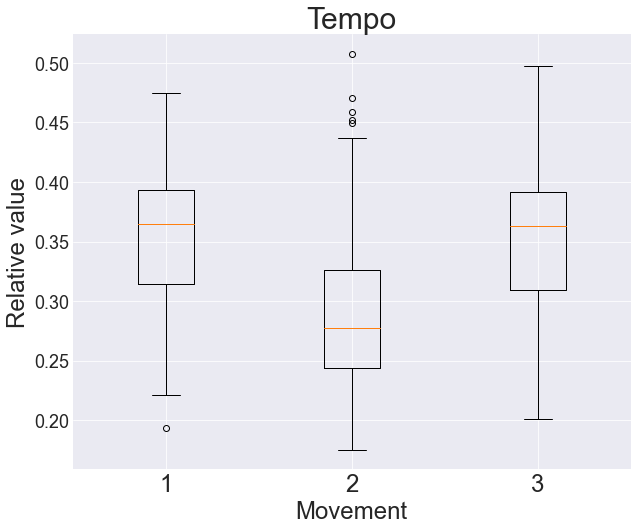

In [32]:

titles = {
    "popularity" : "Spotify popularity", 
    "duration_ms": "Duration",
    "energy": "Energy", 
    "loudness": "Loudness", 
    "speechiness": "Speechiness", 
    "acousticness": "Acousticness", 
    "instrumentalness": "Instrumentalness", 
    "valence": "Valence",
    "tempo": "Tempo",
    "danceability": "Danceability"
}

data = {}
data_abs = {}
for metric in ["popularity", "duration_ms", "energy", "loudness", "speechiness", "acousticness", "instrumentalness", "valence", "tempo"]:
    values = [[], [], []]
    values_abs = [[], [], []]
    concertos = []
    for artist in ordered_tracks:
        for concerto in ordered_tracks[artist]:
            if len(ordered_tracks[artist][concerto]) == 3:
                total = sum([ordered_tracks[artist][concerto][movement][metric] for movement in ordered_tracks[artist][concerto]])
                if total > 0:
                    concertos.append(artist + " -- " + concerto)
                    for i, movement in enumerate(ordered_tracks[artist][concerto]):
                        values[i].append(ordered_tracks[artist][concerto][movement][metric]/total)
                        values_abs[i].append(ordered_tracks[artist][concerto][movement][metric])

    data[metric] = pd.DataFrame(np.array([concertos] + values).transpose(), columns = ["concerto", "movement 1", "movement 2", "movement 3"])
    data[metric]["movement 1"] = pd.to_numeric(data[metric]["movement 1"])
    data[metric]["movement 2"] = pd.to_numeric(data[metric]["movement 2"])
    data[metric]["movement 3"] = pd.to_numeric(data[metric]["movement 3"])
    data_abs[metric] = pd.DataFrame(np.array([concertos] + values_abs).transpose(), columns = ["concerto", "movement 1", "movement 2", "movement 3"])
    data_abs[metric]["movement 1"] = pd.to_numeric(data_abs[metric]["movement 1"])
    data_abs[metric]["movement 2"] = pd.to_numeric(data_abs[metric]["movement 2"])
    data_abs[metric]["movement 3"] = pd.to_numeric(data_abs[metric]["movement 3"])
    
    fig = plt.figure(figsize = (10,8));
    ax = plt.gca()
    boxplot = ax.boxplot(values);
    title = ax.set_title(titles[metric], fontsize=30);
    ax.tick_params(axis='y', which='major', labelsize=18)
    ax.tick_params(axis='x', which='major', labelsize=24)
    ax.set_xlabel("Movement", fontsize=24)
    ax.set_ylabel("Relative value", fontsize=24)
    


### Comparison of energy and popularity in 2nd movements

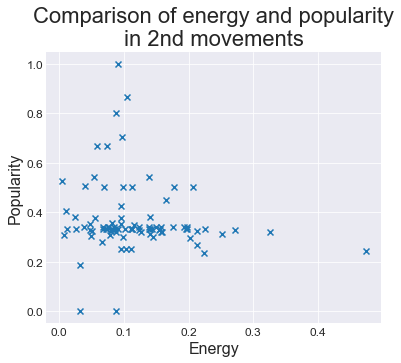

In [34]:
comparison_data = pd.merge(data["energy"], data["popularity"], on="concerto", suffixes=("_eny", "_pop"));
fig = plt.figure(figsize = (6,5));
ax = plt.gca();
scatterplot = ax.scatter(comparison_data["movement 2_eny"], comparison_data["movement 2_pop"], marker="x");
ax.tick_params(axis='y', which='major', labelsize=12);
ax.tick_params(axis='x', which='major', labelsize=12);
ax.set_title("Comparison of energy and popularity\nin 2nd movements", fontsize=22);
ax.set_xlabel("Energy", fontsize=16);
ax.set_ylabel("Popularity", fontsize=16);

All concertos order from most energetic second movement to least.

In [36]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', 100):
    print(data_abs["energy"].sort_values(by=['movement 2'], ascending=False))

                                                                                               concerto  \
80                                          Edward MacDowell -- Piano Concerto No. 2 in D Minor, Op. 23   
78                           Sergei Prokofiev -- Piano Concerto No. 2 in G Minor, Op. 16 (1923 Version)   
68                          Camille Saint-Saëns -- Saint-Saëns: Piano Concerto No. 2 in G Minor, Op. 22   
95                                                Philip Glass -- Piano Concerto No. 3 (2017): Movement   
7                                        Sergei Rachmaninoff -- Piano Concerto No. 3 in D Minor, Op. 30   
70                                          Franz Liszt -- Piano Concerto No. 1 in E-Flat Major, S. 124   
43  Franz Joseph Haydn -- Concerto pour pianoforte et orchestre en Ré majeur, Hob.XVIII:11: Concerto...   
79                                                      Francis Poulenc -- Concerto for 2 Pianos, FP 61   
42  Franz Joseph Haydn -- Concerto po